In [1]:
# load data
import numpy as np
import pickle
import math
import time
import sys
module_paths = ['']
for path in module_paths :
    if path not in sys.path:
        sys.path.append(path)

from utils_load_PHloc import (extract_PH_heatmaps_single_sample,
extract_heatmap_grid,
contour_heatmaps,
collect_paired_crit_sizes,
collect_indiv_crit_sizes)

from utils_load_PHloc import datasets_of_interest, injected_datasets_of_interest, levels_of_interest

# folder where you put the PHloc files
PH_folder = '' 

# choose desired anatomy: 'knee', 'long', 'both' (which is a merge of the birth-death points)
anatomy = 'knee'

# load file
filepath = PH_folder + 'PH_all_{}.pkl'.format(anatomy)
print('I will load',filepath)
PH_all_datasets = pickle.load(open(filepath, 'rb'))

# threshold value
THR = .5

# generate a new dictionary for truncated datasets
truncated_PH_all_datasets = {}
for i in datasets_of_interest:
    diagram = PH_all_datasets[i]
    truncated_PH_all_datasets[i] = diagram[diagram[:,1] >= diagram[:,0] + THR]
    
# print size of the diagrams
for i in datasets_of_interest:
    diagram1 = PH_all_datasets[i]
    diagram2 = truncated_PH_all_datasets[i]
print("done")

names = [injected_datasets_of_interest[i]+"_"+[str(x) for x in datasets_of_interest][i] for i in range(27)]

labels = ['CTRL_0%(1)', 'CTRL_0%(2)', 'CTRL_0%(3)', 'CTRL_0%(4)', 
          'U937_1%(1)', 'U937_1%(2)', 'U937_7%', 'U937_8%', 'U937_10%(1)', 'U937_10%(2)', 'U937_10%(3)', 
          'HL60_23%', 'HL60_25%(1)', 'HL60_25%(2)', 
          'P1_10%', 'P1_40%', 'P1_44%', 'P1_51%', 'P1_60%', 'P1_76%', 
          'P2_59%', 'P2_88%', 'P2_90%', 
          'MNC_53%', 'MNC_67%', 'MNC_75%', 'MNC_86%']

phases_of_interest = [0,0,0,0,
         1,1,1,1,1,1,1,
         1,1,1,
         1,2,2,2,2,1,
         2,2,2,
         1,2,2,2]

name_phase = [labels[i]+" [Phase "+str(phases_of_interest[i])+"]" for i in range(27)]

import matplotlib.pyplot as plt

################ PARAMETERS

# default values used: WEIGHTS = True (dirac masses weighted by persistence) ; SIGMA = .5

WEIGHTS = True
SIGMA = .5

# Binning parameters
XLIMS = np.array([[-15,0],[-10,10],[0,20]])
YLIMS = np.array([[-8,7],[-5,15],[0,20]])
NB_BINS_PER_SIDE = 100

groups_of_interest = [0,0,0,0,
                          1,1,2,2,2,1,2,
                          1,1,2,
                          1,1,3,3,3,1,
                          3,3,3,
                          1,3,3,3]

name_group = [labels[i]+" [Group "+str(groups_of_interest[i])+"]" for i in range(27)]

# load modules and get ph0_sw
import pomegranate
import sklearn

import torch

from pomegranate.gmm import GeneralMixtureModel
from pomegranate.distributions import *

# obtain ph1_ne points

pds = [truncated_PH_all_datasets[i] for i in datasets_of_interest]

ph1 = []
for i in range(27):
    current_pd = pds[i]
    ph1.append(current_pd[current_pd[:,2]==1,:])
    
ph1 = [ph1[i][:,:2] for i in range(27)]

ph1_sw = []
for i in range(27):
    current = ph1[i]
    x = current[:,0]
    y = current[:,1]
    ph1_sw.append(current[(x<0)*(y<0),:])
    

phase0_index = [0,1,2,3]
phase1_index = [4,5,6,7,8,9,10,11,12,13,14,19,23]
phase2_index = [15,16,17,18,20,21,22,24,25,26]

phase0_ph1sw = [ph1_sw[x] for x in phase0_index]
phase1_ph1sw = [ph1_sw[x] for x in phase1_index]
phase2_ph1sw = [ph1_sw[x] for x in phase2_index]


#stacking points of the same phase together
phase0_pts = np.vstack(phase0_ph1sw)
phase1_pts = np.vstack(phase1_ph1sw)
phase2_pts = np.vstack(phase2_ph1sw)

allphase_pts = np.vstack(ph1_sw)


def single_weighted_contour_map(diag, sigma = 0.5, xlims = [-10,10], ylims = [-5,15], nb_bins_per_side = 100, option = "sklearn"):
    
    weights = diag[:,1]-diag[:,0]
    
    img = extract_heatmap_grid(diag, weights = weights, sigma = sigma,
                        xlim = xlims, ylim = ylims, nb_bins_per_side = nb_bins_per_side,
                         option = option)

    EXTENT = [-10, 10, -5, 15]

    plt.imshow(img, extent = EXTENT, cmap = 'magma')

    plt.contour(img, levels = 4, extent = EXTENT, #img.max()*np.arange(1,5)/5
               origin = 'upper', cmap = 'inferno_r')
    
    plt.tight_layout()
    plt.show() 

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode
I will load PH_all_knee.pkl
done


In [15]:
# model sizes ranging from 2 to 20 (19 in total)

models = [] # list of 19 x 3 models
times = [] # 19 times
ind_loglikelihoods = [] # list of 19 x 3 x ... individual loglikelihoods
bics = [] # list of 19 x 3 x ... individual bics
bic_tols = [] # sum bic for each model size
# we are really only interested in "times" and "bic_tols"
for i in range(19):
    # start timing
    start_time = time.time()
    # fit model for phase 0
    model0 = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=i+2,     #Required if single function passed as first arg
        X=phase0_pts,     #data format: each row is a point-coordinate, each column is a dimension
        )
    model0.fit(
        X=phase0_pts,         #data format: each row is a coordinate, each column is a dimension
        weights = phase0_pts[:,1]-phase0_pts[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    model1 = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=i+2,     #Required if single function passed as first arg
        X=phase1_pts,     #data format: each row is a point-coordinate, each column is a dimension
        )
    model1.fit(
        X=phase1_pts,         #data format: each row is a coordinate, each column is a dimension
        weights = phase1_pts[:,1]-phase1_pts[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    model2 = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=i+2,     #Required if single function passed as first arg
        X=phase2_pts,     #data format: each row is a point-coordinate, each column is a dimension
        )
    model2.fit(
        X=phase2_pts,         #data format: each row is a coordinate, each column is a dimension
        weights = phase2_pts[:,1]-phase2_pts[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    times.append(time.time()-start_time)
    models.append([model0,model1,model2])
    
    # compute loglikelihoods on individual sample level
    
    # phase 0
    bic_sum = 0
    loglike_record0 = []
    bic_record0 = []
    for datas in phase0_ph1sw:
        n = datas.shape[0]
        loglike = np.sum(model0.log_probability(datas))
        loglike_record0.append(loglike)
        bic_record0.append(-2*loglike+math.log(n)*6*(i+2))
    bic_sum += sum(bic_record0)
    
    # phase 1
    loglike_record1 = []
    bic_record1 = []
    for datas in phase1_ph1sw:
        n = datas.shape[0]
        loglike = np.sum(model1.log_probability(datas))
        loglike_record1.append(loglike)
        bic_record1.append(-2*loglike+math.log(n)*6*(i+2))
    bic_sum += sum(bic_record1)
    
    # phase 2
    loglike_record2 = []
    bic_record2 = []
    for datas in phase2_ph1sw:
        n = datas.shape[0]
        loglike = np.sum(model2.log_probability(datas))
        loglike_record2.append(loglike)
        bic_record2.append(-2*loglike+math.log(n)*6*(i+2))
    bic_sum += sum(bic_record2)
    
    # appending...
    ind_loglikelihoods.append([loglike_record0, loglike_record1, loglike_record2])
    bics.append([bic_record0, bic_record1, bic_record2])
    bic_tols.append(bic_sum)
    
    print("model size = {} - done".format(i+2))
    

model size = 2 - done
model size = 3 - done
model size = 4 - done
model size = 5 - done
model size = 6 - done
model size = 7 - done
model size = 8 - done
model size = 9 - done
model size = 10 - done
model size = 11 - done
model size = 12 - done
model size = 13 - done
model size = 14 - done
model size = 15 - done
model size = 16 - done
model size = 17 - done
model size = 18 - done
model size = 19 - done
model size = 20 - done


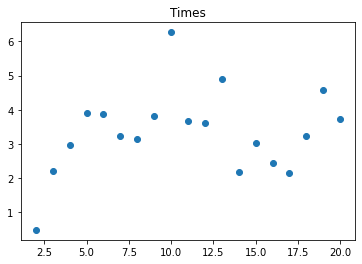

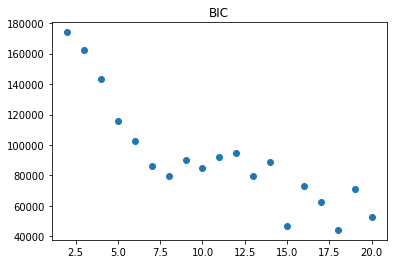

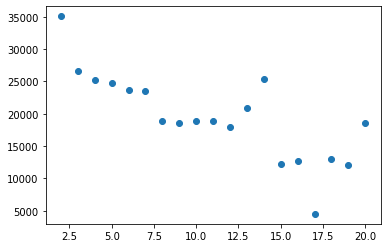

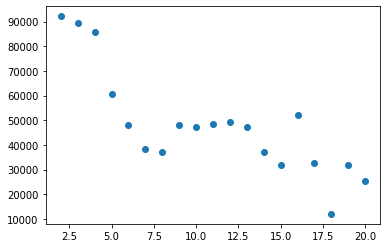

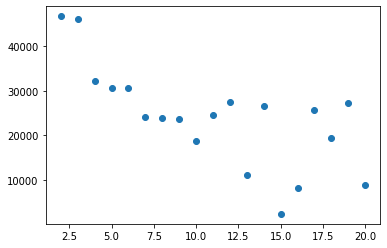

In [16]:
x_val = [i+2 for i in range(19)]
plt.scatter(x_val, times)
plt.title("Times")
plt.show()

plt.scatter(x_val, bic_tols)
plt.title("BIC")
plt.show()

plt.scatter(x_val, [sum(bics[i][0]) for i in range(19)])
plt.show()

plt.scatter(x_val, [sum(bics[i][1]) for i in range(19)])
plt.show()

plt.scatter(x_val, [sum(bics[i][2]) for i in range(19)])
plt.show()

In [46]:
# collect all with 3 clusters
cluster3_models = []
for i in range(27):
    model = pomegranate.gmm.GeneralMixtureModel.from_samples(
        pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
        n_components=7,     #Required if single function passed as first arg
        X=ph1_sw[i],     #data format: each row is a point-coordinate, each column is a dimension
        )
    model.fit(
        X=ph1_sw[i],         #data format: each row is a coordinate, each column is a dimension
        weights = ph1_sw[i][:,1]-ph1_sw[i][:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    cluster3_models.append(model)
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [8]:
def kl_divergence(model1, model2):
    x = np.arange(-10,10,.1)
    y = np.arange(-5,15,.1)
    xx,yy = np.meshgrid(x,y)
    x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

    p1 = model1.probability(x_).reshape(len(x),len(y))
    p2 = model2.probability(x_).reshape(len(x),len(y))
     
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    
    return np.sum(p1*(np.log(p1/p2))) 

# Hellinger distance
def Hellinger(model1, model2):
    x = np.arange(-10,10,.1)
    y = np.arange(-5,15,.1)
    xx,yy = np.meshgrid(x,y)
    x_ = np.array(list(zip(xx.flatten(), yy.flatten())))

    p1 = model1.probability(x_).reshape(len(x),len(y))
    p2 = model2.probability(x_).reshape(len(x),len(y))
     
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    
    summation = np.sum(np.square(np.sqrt(p1)-np.sqrt(p2)))   
    
    return np.sqrt(summation)/np.sqrt(2)
  

colours_of_interest = []
for i in phases_of_interest:
    if i == 0:
        colours_of_interest.append("green")
    elif i == 1:
        colours_of_interest.append("orange")
    elif i == 2:
        colours_of_interest.append("red")

# Bootstrap

In [2]:
# shuffle each array and take 50-50 split
ph1_train = []
ph1_test = []
for i in range(27):
    current_ph1 = ph1_sw[i]
    n_tot = current_ph1.shape[0]
    n_val = int(np.floor(n_tot*0.5))
    np.random.shuffle(current_ph1)
    ph1_train.append(current_ph1[:n_val,:])
    ph1_test.append(current_ph1[n_val:,:])
    
for i in range(27):
    print("train size: {}, test size {}".format(ph1_train[i].shape[0], ph1_test[i].shape[0]))

train size: 1314, test size 1315
train size: 745, test size 745
train size: 1096, test size 1096
train size: 1262, test size 1262
train size: 451, test size 451
train size: 962, test size 962
train size: 1233, test size 1233
train size: 1193, test size 1193
train size: 1382, test size 1383
train size: 605, test size 605
train size: 818, test size 819
train size: 865, test size 865
train size: 942, test size 942
train size: 712, test size 712
train size: 1373, test size 1374
train size: 605, test size 605
train size: 685, test size 686
train size: 588, test size 588
train size: 931, test size 932
train size: 550, test size 551
train size: 663, test size 664
train size: 479, test size 480
train size: 350, test size 350
train size: 727, test size 727
train size: 504, test size 505
train size: 709, test size 709
train size: 357, test size 357


In [3]:
# grouping


phase0_train = [ph1_train[x] for x in phase0_index]
phase1_train = [ph1_train[x] for x in phase1_index]
phase2_train = [ph1_train[x] for x in phase2_index]

# stacking the training pts together
phase0_train_pts = np.vstack(phase0_train)
phase1_train_pts = np.vstack(phase1_train)
phase2_train_pts = np.vstack(phase2_train)

phase0_test = [ph1_test[x] for x in phase0_index]
phase1_test = [ph1_test[x] for x in phase1_index]
phase2_test = [ph1_test[x] for x in phase2_index]

# stacking the test pts together
phase0_test_pts = np.vstack(phase0_test)
phase1_test_pts = np.vstack(phase1_test)
phase2_test_pts = np.vstack(phase2_test)

# fit an initial model using half of the data as starting parameters
# take a bootstrap of size half the data
n0 = phase0_train_pts.shape[0]
n1 = phase1_train_pts.shape[0]
n2 = phase2_train_pts.shape[0]

choice0 = np.random.choice([i for i in range(n0)], size=int(np.floor(n0/2)), replace=True)
x0 = phase0_train_pts[choice0,:]

choice1 = np.random.choice([i for i in range(n1)], size=int(np.floor(n1/2)), replace=True)
x1 = phase1_train_pts[choice1,:]

choice2 = np.random.choice([i for i in range(n2)], size=int(np.floor(n2/2)), replace=True)
x2 = phase2_train_pts[choice2,:]


model0 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=4,     #Required if single function passed as first arg
    X=x0,     #data format: each row is a point-coordinate, each column is a dimension
    )
model0.fit(
    X=x0,         #data format: each row is a coordinate, each column is a dimension
    weights = x0[:,1]-x0[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );
model1 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=5,     #Required if single function passed as first arg
    X=x1,     #data format: each row is a point-coordinate, each column is a dimension
    )
model1.fit(
    X=x1,         #data format: each row is a coordinate, each column is a dimension
    weights = x1[:,1]-x1[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );
model2 = pomegranate.gmm.GeneralMixtureModel.from_samples(
    pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
    n_components=6,     #Required if single function passed as first arg
    X=x2,     #data format: each row is a point-coordinate, each column is a dimension
    )
model2.fit(
    X=x2,         #data format: each row is a coordinate, each column is a dimension
    weights = x2[:,1]-x2[:,0],  #List of weights. One for each point-coordinate
    stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                            #   (sklearn likes better/slower fits than pomegrante by default)
    );


In [4]:
# record the following
weights0 = []
means0 = []
variances0 = []

weights1 = []
means1 = []
variances1 = []

weights2 = []
means2 = []
variances2 = []

# take 50 bootstrap samples each being a quarter of the original size
for t in range(50):
    
    choice0 = np.random.choice([i for i in range(n0)], size=int(np.floor(n0/4)), replace=True)
    x0 = phase0_train_pts[choice0,:]

    choice1 = np.random.choice([i for i in range(n1)], size=int(np.floor(n1/4)), replace=True)
    x1 = phase1_train_pts[choice1,:]

    choice2 = np.random.choice([i for i in range(n2)], size=int(np.floor(n2/4)), replace=True)
    x2 = phase2_train_pts[choice2,:]
    
    phase0_model = model0
    phase1_model = model1
    phase2_model = model2
    
    # update the model using the bootstrap samples
    phase0_model.fit(
        X=x0,         #data format: each row is a coordinate, each column is a dimension
        weights = x0[:,1]-x0[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    phase1_model.fit(
        X=x1,         #data format: each row is a coordinate, each column is a dimension
        weights = x1[:,1]-x1[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    phase2_model.fit(
        X=x2,         #data format: each row is a coordinate, each column is a dimension
        weights = x2[:,1]-x2[:,0],  #List of weights. One for each point-coordinate
        stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                #   (sklearn likes better/slower fits than pomegrante by default)
        )
    # record model parameters
    weights0.append(np.exp(phase0_model.weights))
    means0.append([phase0_model.distributions[j].parameters[0] for j in range(4)])
    variances0.append([phase0_model.distributions[j].parameters[1] for j in range(4)])

    weights1.append(np.exp(phase1_model.weights))
    means1.append([phase1_model.distributions[j].parameters[0] for j in range(5)])
    variances1.append([phase1_model.distributions[j].parameters[1] for j in range(5)])
    
    weights2.append(np.exp(phase2_model.weights))
    means2.append([phase2_model.distributions[j].parameters[0] for j in range(6)])
    variances2.append([phase2_model.distributions[j].parameters[1] for j in range(6)])
    
    print("{}-th bootstrap complete".format(t))
    
    
    

0-th bootstrap complete
1-th bootstrap complete
2-th bootstrap complete
3-th bootstrap complete
4-th bootstrap complete
5-th bootstrap complete
6-th bootstrap complete
7-th bootstrap complete
8-th bootstrap complete
9-th bootstrap complete
10-th bootstrap complete
11-th bootstrap complete
12-th bootstrap complete
13-th bootstrap complete
14-th bootstrap complete
15-th bootstrap complete
16-th bootstrap complete
17-th bootstrap complete
18-th bootstrap complete
19-th bootstrap complete
20-th bootstrap complete
21-th bootstrap complete
22-th bootstrap complete
23-th bootstrap complete
24-th bootstrap complete
25-th bootstrap complete
26-th bootstrap complete
27-th bootstrap complete
28-th bootstrap complete
29-th bootstrap complete
30-th bootstrap complete
31-th bootstrap complete
32-th bootstrap complete
33-th bootstrap complete
34-th bootstrap complete
35-th bootstrap complete
36-th bootstrap complete
37-th bootstrap complete
38-th bootstrap complete
39-th bootstrap complete
40-th boot

In [5]:
# Take average of the parameters
mu0 = np.mean(np.array(means0), axis=0)
mu1 = np.mean(np.array(means1), axis=0)
mu2 = np.mean(np.array(means2), axis=0)

w0 = np.mean(np.array(weights0), axis=0)
w1 = np.mean(np.array(weights1), axis=0)
w2 = np.mean(np.array(weights2), axis=0)

cov0 = np.mean(np.array(variances0), axis=0)
cov1 = np.mean(np.array(variances1), axis=0)
cov2 = np.mean(np.array(variances2), axis=0)


# construct the Gaussian mixtures
# phase 0
mixture0 = [MultivariateGaussianDistribution(mu0[i], cov0[i]) for i in range(4)]
Model0 = GeneralMixtureModel(mixture0 , weights=w0)

# phase 1
mixture1 = [MultivariateGaussianDistribution(mu1[i], cov1[i]) for i in range(5)]
Model1 = GeneralMixtureModel(mixture1 , weights=w1)

# phase 2
mixture2 = [MultivariateGaussianDistribution(mu2[i], cov2[i]) for i in range(6)]
Model2 = GeneralMixtureModel(mixture2 , weights=w2)


In [6]:

# construct the Gaussian mixtures
# phase 0
mixture0 = [MultivariateGaussianDistribution(mu0[i], cov0[i]) for i in range(4)]
Model0 = GeneralMixtureModel(mixture0 , weights=w0)

# phase 1
mixture1 = [MultivariateGaussianDistribution(mu1[i], cov1[i]) for i in range(5)]
Model1 = GeneralMixtureModel(mixture1 , weights=w1)

# phase 2
mixture2 = [MultivariateGaussianDistribution(mu2[i], cov2[i]) for i in range(6)]
Model2 = GeneralMixtureModel(mixture2 , weights=w2)


In [9]:
kl0s = [[] for i in range(27)]
kl1s = [[] for i in range(27)]
kl2s = [[] for i in range(27)]

h0s = [[] for i in range(27)]
h1s = [[] for i in range(27)]
h2s = [[] for i in range(27)]

# size of each ph diagram
sizes = [item.shape[0] for item in ph1_test]

for t in range(50):
    # subsample
    cluster3_models = []
    for i in range(27):
        n = sizes[i]
        indices = np.random.choice([i for i in range(n)], size=int(np.floor(n/4)), replace=True)
        sample = ph1_test[i][indices,:]
        
        model = pomegranate.gmm.GeneralMixtureModel.from_samples(
            pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
            n_components=3,     #Required if single function passed as first arg
            X=sample,     #data format: each row is a point-coordinate, each column is a dimension
            )
        model.fit(
            X=sample,         #data format: each row is a coordinate, each column is a dimension
            weights = sample[:,1]-sample[:,0],  #List of weights. One for each point-coordinate
            stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                    #   (sklearn likes better/slower fits than pomegrante by default)
            )
        cluster3_models.append(model)
    # compute kl
    for i in range(27):
        kl0s[i].append(kl_divergence(Model0,cluster3_models[i]))
        kl1s[i].append(kl_divergence(Model1,cluster3_models[i]))
        kl2s[i].append(kl_divergence(Model2,cluster3_models[i]))
        
    for i in range(27):
        h0s[i].append(Hellinger(Model0, cluster3_models[i]))
        h1s[i].append(Hellinger(Model1, cluster3_models[i]))
        h2s[i].append(Hellinger(Model2, cluster3_models[i]))
        
    print("{}-th bootstrap done".format(t))

/home/qw817/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]
/home/qw817/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in multiply
  del sys.path[0]
/home/qw817/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/qw817/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


0-th bootstrap done
1-th bootstrap done
2-th bootstrap done
3-th bootstrap done
4-th bootstrap done
5-th bootstrap done
6-th bootstrap done
7-th bootstrap done
8-th bootstrap done
9-th bootstrap done
10-th bootstrap done
11-th bootstrap done
12-th bootstrap done
13-th bootstrap done
14-th bootstrap done
15-th bootstrap done
16-th bootstrap done
17-th bootstrap done
18-th bootstrap done
19-th bootstrap done
20-th bootstrap done
21-th bootstrap done
22-th bootstrap done
23-th bootstrap done
24-th bootstrap done
25-th bootstrap done
26-th bootstrap done
27-th bootstrap done


/home/qw817/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in true_divide
  del sys.path[0]


28-th bootstrap done
29-th bootstrap done
30-th bootstrap done
31-th bootstrap done
32-th bootstrap done
33-th bootstrap done
34-th bootstrap done
35-th bootstrap done
36-th bootstrap done
37-th bootstrap done
38-th bootstrap done
39-th bootstrap done
40-th bootstrap done
41-th bootstrap done
42-th bootstrap done
43-th bootstrap done
44-th bootstrap done
45-th bootstrap done
46-th bootstrap done
47-th bootstrap done
48-th bootstrap done
49-th bootstrap done


In [10]:
import pickle
dat = kl0s, kl1s, kl2s, h0s,h1s, h2s
pickle.dump(dat, open('ph1_sw_dists.pkl','wb'))

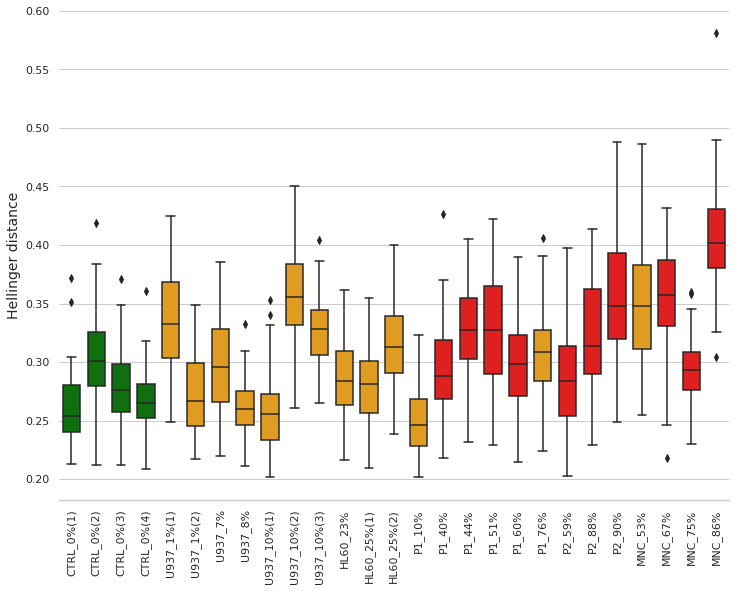

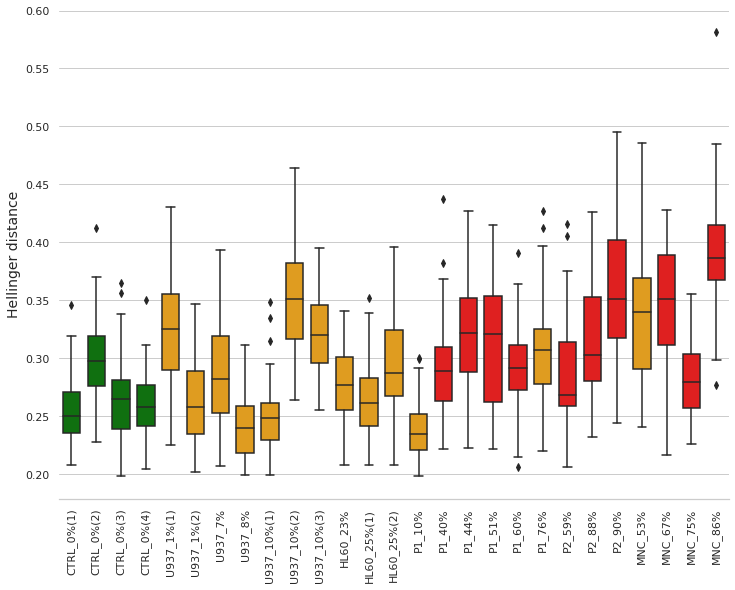

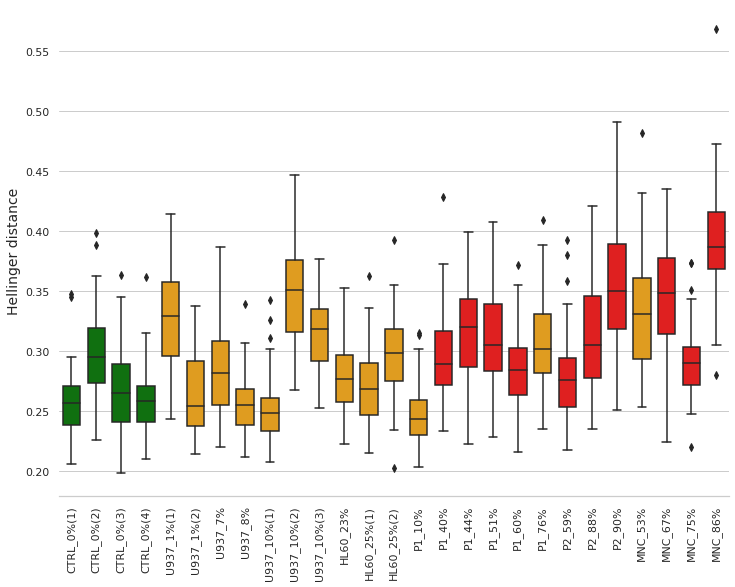

In [59]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

df_h0 = pd.DataFrame(h0s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h0.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

########################################################
df_h1 = pd.DataFrame(h1s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h1.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

#########################################################
df_h2 = pd.DataFrame(h2s, index=labels)

sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(12, 9))
xvalues = labels
palette = colours_of_interest

melted_df = df_h2.T.set_axis(xvalues, axis=1).melt(var_name='Sample', value_name='Hellinger distance')
sns.boxplot(data=melted_df, x='Sample', y='Hellinger distance', hue='Sample', palette=palette,
            width=0.7, dodge=False, ax=ax)

ax.legend_.remove()  # remove the legend, as the information is already present in the x labels
ax.set_xlabel('')  # remove unuseful xlabel ('Variable')
ax.set_ylabel("Hellinger distance", fontsize=14)


sns.despine(top=True, right=True, left=True, bottom=False)
plt.xticks(rotation=90)
plt.show()

In [60]:
# record the accuracy for each sample
accuracies = [0 for i in range(27)]

for i in range(27):
    # 50 bootstrap iterations
    correct = 0
    for j in range(50):
        # sample
        n = sizes[i]
        indices = np.random.choice([l for l in range(n)], size=int(np.floor(n/4)), replace=True)
        sample = ph1_test[i][indices,:]
        
        # model 
        model = pomegranate.gmm.GeneralMixtureModel.from_samples(
            pomegranate.MultivariateGaussianDistribution,   #Either single function, or list of functions
            n_components=3,     #Required if single function passed as first arg
            X=sample,     #data format: each row is a point-coordinate, each column is a dimension
            )
        model.fit(
            X=sample,         #data format: each row is a coordinate, each column is a dimension
            weights = sample[:,1]-sample[:,0],  #List of weights. One for each point-coordinate
            stop_threshold = .001,  #Lower this value to get better fit but take longer. 
                                    #   (sklearn likes better/slower fits than pomegrante by default)
            )
        
        # compute the hellinger distance to the 3 models
        hdist = [Hellinger(Model0, model), Hellinger(Model1, model), Hellinger(Model2, model)]
        pred = hdist.index(min(hdist))
        if pred == phases_of_interest[i]:
            correct +=1
    print("{} is done".format(i))
    accuracies[i] = correct

0 is done
1 is done
2 is done
3 is done
4 is done
5 is done
6 is done
7 is done
8 is done
9 is done
10 is done
11 is done
12 is done
13 is done
14 is done
15 is done
16 is done
17 is done
18 is done
19 is done
20 is done
21 is done
22 is done
23 is done
24 is done
25 is done
26 is done


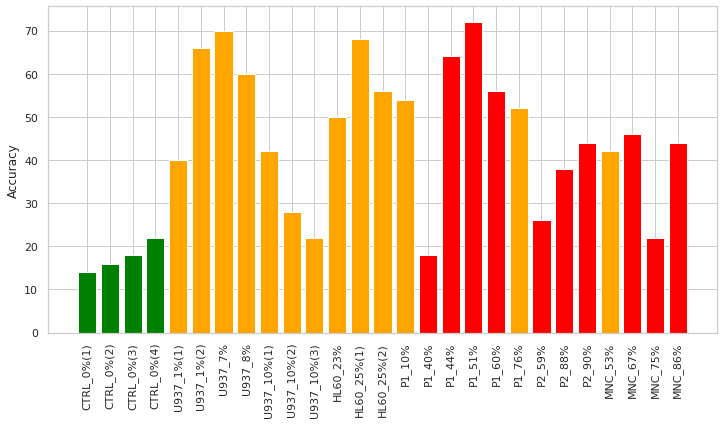

In [61]:
cel_labels = []
for item in phases_of_interest:
    if item==0:
        cel_labels.append('CTRL')
    elif item==1:
        cel_labels.append('EARLY')
    elif item==2:
        cel_labels.append('LATE')

fig, ax = plt.subplots(figsize = (12,6))

for i in range(27):
    ax.bar(labels[i], (np.array(accuracies)*2)[i], color=colours_of_interest[i], label=cel_labels[i])
#plt.legend()
plt.xticks(rotation= 90)
plt.ylabel("Accuracy")
plt.show()

In [62]:
sum(accuracies)/(50*27)

0.42592592592592593